In [1]:
pip install torch torchvision matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [2]:
dataset_choice = "mnist"     # fixed to MNIST
epochs = 50
batch_size = 64
noise_dim = 100
learning_rate = 0.0002
sample_interval = 5          # save images every N epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
os.makedirs("generated_samples", exist_ok=True)
os.makedirs("final_generated_images", exist_ok=True)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root="./data",
        train=True,
        transform=transform,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.87MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 1, 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [9]:
for epoch in range(1, epochs + 1):
    for imgs, _ in train_loader:

        real_imgs = imgs.to(device)
        batch_size_curr = real_imgs.size(0)

        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # -----------------
        # Train Discriminator
        # -----------------
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), real_labels)

        z = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

    # -----------------------------
    # Logging
    # -----------------------------
    print(
        f"Epoch [{epoch}/{epochs}] "
        f"D_loss: {d_loss.item():.4f} "
        f"G_loss: {g_loss.item():.4f}"
    )

    # -----------------------------
    # Save Generated Samples
    # -----------------------------
    if epoch % sample_interval == 0:
        z = torch.randn(25, noise_dim).to(device)
        samples = generator(z)
        grid = make_grid(samples, nrow=5, normalize=True)
        save_image(grid, f"generated_samples/epoch_{epoch}.png")

Epoch [1/50] D_loss: 0.2851 G_loss: 3.8509
Epoch [2/50] D_loss: 0.3030 G_loss: 2.8037
Epoch [3/50] D_loss: 0.5459 G_loss: 3.0740
Epoch [4/50] D_loss: 0.1857 G_loss: 3.6590
Epoch [5/50] D_loss: 0.2403 G_loss: 16.1442
Epoch [6/50] D_loss: 0.0512 G_loss: 4.7601
Epoch [7/50] D_loss: 0.0006 G_loss: 7.4982
Epoch [8/50] D_loss: 0.0012 G_loss: 6.9928
Epoch [9/50] D_loss: 0.0000 G_loss: 10.5619
Epoch [10/50] D_loss: 0.0000 G_loss: 10.8757
Epoch [11/50] D_loss: 0.0000 G_loss: 10.7875
Epoch [12/50] D_loss: 0.0000 G_loss: 50.2416
Epoch [13/50] D_loss: 0.0000 G_loss: 50.3583
Epoch [14/50] D_loss: 0.0000 G_loss: 50.2042
Epoch [15/50] D_loss: 0.0000 G_loss: 50.2275
Epoch [16/50] D_loss: 0.0000 G_loss: 50.1917
Epoch [17/50] D_loss: 0.0000 G_loss: 50.2943
Epoch [18/50] D_loss: 0.0000 G_loss: 50.2285
Epoch [19/50] D_loss: 0.0000 G_loss: 50.1156
Epoch [20/50] D_loss: 0.0000 G_loss: 50.2147
Epoch [21/50] D_loss: 0.0000 G_loss: 50.1409
Epoch [22/50] D_loss: 0.0000 G_loss: 50.1893
Epoch [23/50] D_loss: 0.00

In [10]:
z = torch.randn(100, noise_dim).to(device)
final_images = generator(z)

for i in range(100):
    save_image(
        final_images[i],
        f"final_generated_images/image_{i+1}.png",
        normalize=True
    )

print("Training complete. Final images saved.")

Training complete. Final images saved.


In [11]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

classifier = MNISTClassifier().to(device)

In [12]:
optimizer_C = optim.Adam(classifier.parameters(), lr=0.001)
criterion_C = nn.CrossEntropyLoss()

classifier.train()
for epoch in range(3):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_C.zero_grad()
        loss = criterion_C(classifier(imgs), labels)
        loss.backward()
        optimizer_C.step()

In [29]:
import torch.nn.functional as F

# Convert range [-1,1] → [0,1]
gan_images = (final_images + 1) / 2

# 1 channel → 3 channels
gan_images = gan_images.repeat(1, 3, 1, 1)

# Resize 28×28 → 224×224
gan_images = F.interpolate(
    gan_images, size=(224, 224), mode="bilinear", align_corners=False
)

gan_images = gan_images.to(device)


In [31]:
classifier = classifier.to(device)
classifier.eval()

for p in classifier.parameters():
    p.requires_grad = False


In [32]:
gan_images = gan_images.to(device)


In [34]:
# ---- make sure classifier is on device ----
classifier = classifier.to(device)
classifier.eval()
for p in classifier.parameters():
    p.requires_grad = False

# ---- preprocess GAN images ----
import torch.nn.functional as F

gan_images = (final_images + 1) / 2
gan_images = gan_images.repeat(1, 3, 1, 1)
gan_images = F.interpolate(
    gan_images, size=(224, 224), mode="bilinear", align_corners=False
)
gan_images = gan_images.to(device)

# ---- inference ----
with torch.no_grad():
    preds = classifier(gan_images)
    predicted_labels = torch.argmax(preds, dim=1)

print("Predicted label distribution:")
for digit in range(10):
    print(f"Digit {digit}: {(predicted_labels == digit).sum().item()}")


Predicted label distribution:
Digit 0: 0
Digit 1: 0
Digit 2: 0
Digit 3: 0
Digit 4: 0
Digit 5: 0
Digit 6: 0
Digit 7: 0
Digit 8: 0
Digit 9: 0


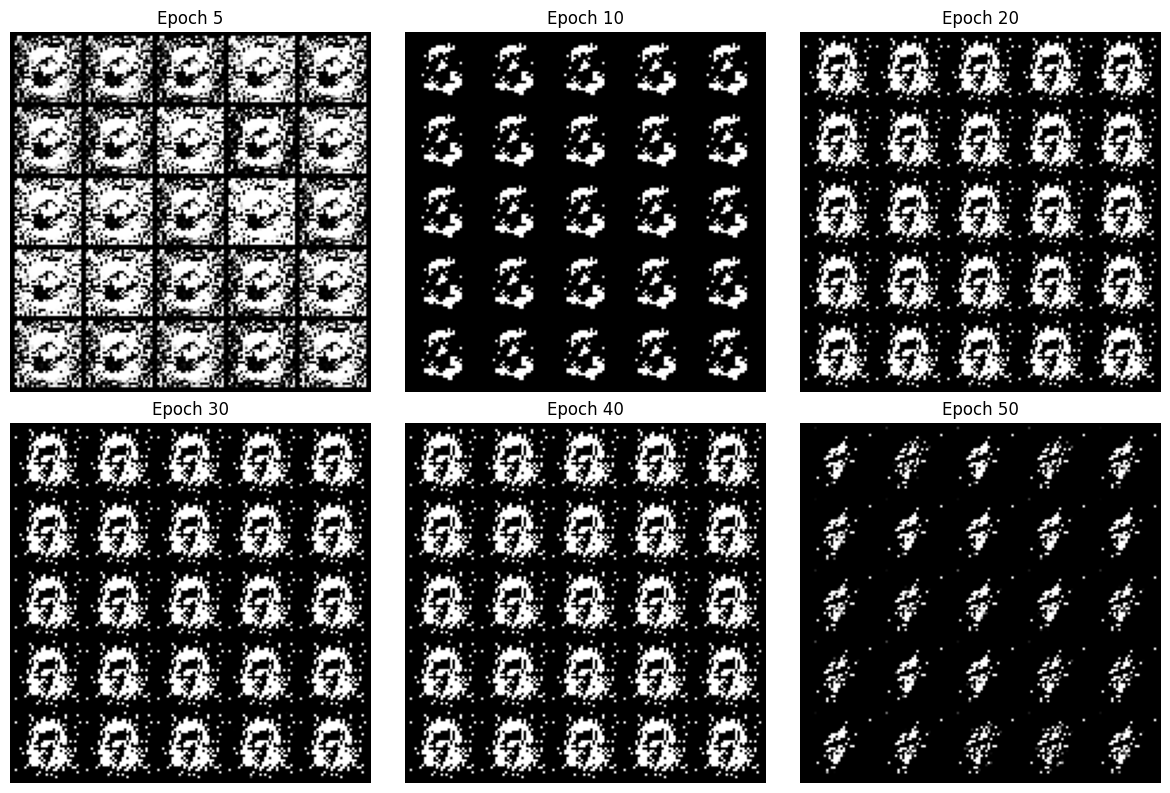

In [35]:
import matplotlib.pyplot as plt
from PIL import Image

epochs = [5, 10, 20, 30, 40, 50]

plt.figure(figsize=(12, 8))

for i, ep in enumerate(epochs):
    img = Image.open(f"generated_samples/epoch_{ep}.png")
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Epoch {ep}")

plt.tight_layout()
plt.show()
